## Imports

In [53]:
import numpy as np
import pandas as pd
from scipy import stats
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns



## Read in CSV

In [8]:
path = '../CSVs/nyc_taxis.csv'

In [6]:
df = pd.read_csv(path)

In [10]:
dateparse = lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
date_cols = ['pickup_datetime','dropoff_datetime']

df = pd.read_csv(path, parse_dates=date_cols, date_parser=dateparse)

In [11]:
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


## 2) Feature Generation

In [12]:
def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)
    All args must be of equal length.
    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

In [15]:
df['trip_dist'] = df.apply(lambda row: haversine_np(row.pickup_longitude,row.pickup_latitude,row.dropoff_longitude,row.dropoff_latitude),axis=1)

In [19]:
df['avg_speed'] = df['trip_dist'] / df['trip_duration']

In [22]:
df['weekday'] = df['pickup_datetime'].dt.day_name()

In [23]:
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,trip_dist,avg_speed,weekday
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,1.497580,0.003291,Monday
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,1.804374,0.002722,Sunday
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,6.381090,0.003004,Tuesday
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,1.484566,0.003461,Wednesday
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,1.187842,0.002731,Saturday


## 1) Data Cleaning

<AxesSubplot:ylabel='Frequency'>

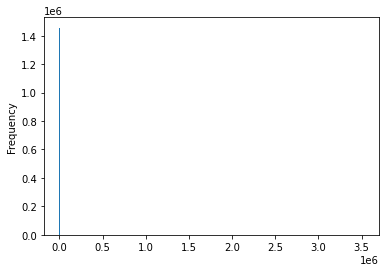

In [26]:
df.trip_duration.plot.hist(bins=500)

<AxesSubplot:ylabel='Frequency'>

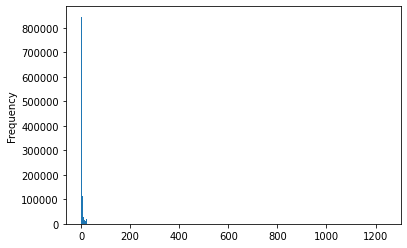

In [27]:
df.trip_dist.plot.hist(bins=500)

<AxesSubplot:ylabel='Frequency'>

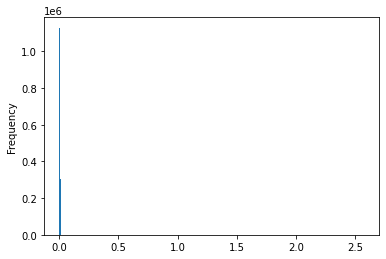

In [28]:
df.avg_speed.plot.hist(bins=500)

<AxesSubplot:ylabel='Frequency'>

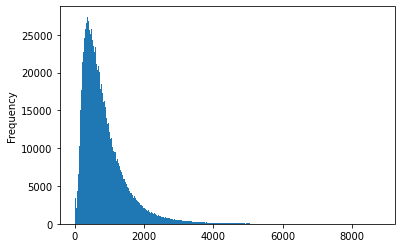

In [40]:
df_new = df.copy()
df_new = df_new[(np.abs(stats.zscore(df_new['trip_duration'],nan_policy='omit')) < 1.5)]
df_new.trip_duration.plot.hist(bins=500)


<AxesSubplot:ylabel='Frequency'>

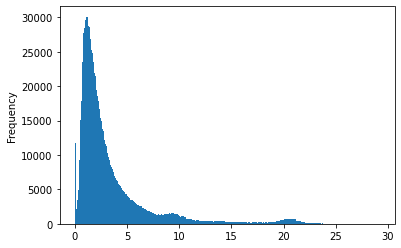

In [46]:
df_new = df.copy()
df_new = df_new[(np.abs(stats.zscore(df_new['trip_dist'],nan_policy='omit')) < 6)]
df_new.trip_dist.plot.hist(bins=500)

<AxesSubplot:ylabel='Frequency'>

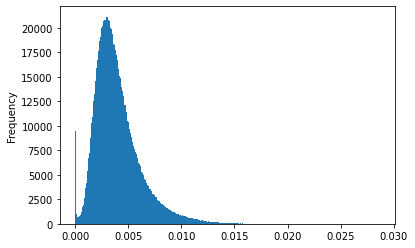

In [47]:
df_new = df.copy()
df_new = df_new[(np.abs(stats.zscore(df_new['avg_speed'],nan_policy='omit')) < 6)]
df_new.avg_speed.plot.hist(bins=500)

The above plots all show the data to be positively skewed and somewhat leptokurtic. We use histogram based outlier removal to remove outliers that lie beyond the tapering of the tails.

In [48]:
df = df[df['trip_duration'] < 6000]
df = df[df['trip_dist'] < 30]
df = df[df['avg_speed'] < 0.02]


## 3) Time-based

In [51]:
def plot_distribution(column, df):
    fig, ax = plt.subplots()
    df[column].astype(np.int64).plot.hist(ax=ax,bins=100)
    labels = ax.get_xticks().tolist()
    labels = pd.to_datetime(labels)
    ax.set_xticklabels(labels, rotation=90)
    plt.show()

### 3.1)

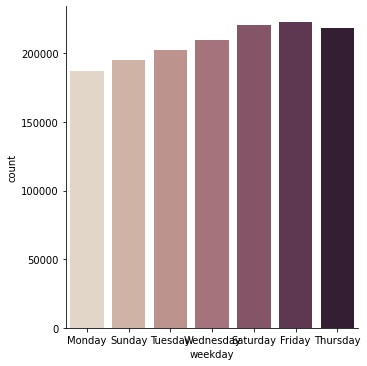

In [54]:
sns.catplot(x="weekday", kind="count", palette="ch:.25", data=df)

Friday is the most popular day

### 3.2)